In [54]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import os

# Measuring the "time of arrival" of a pulsar
## Crab Pulsar Experiment Part 3.2

This notebook can be used for the first part of the crab timing part of the experiment. Here you will find code that reads your data files (pulsar archives) and matches the observed pulse against a _standard template_ of the crab pulsar. This standard template is a noise-free model of the shape of the pulse and we can measure the time that the pulse arrived to very high precision by correlating the known shape of the pulse (the template) with the noisy data.

The code is in four main parts:
 1. Specifying the data location
 2. Dedispersion of the data ( **insert your code from Part 1 here** )
 3. Measuring the time of arrival (ToA)
 4. Visualising the result
 
_You will need to run all three parts in sequence to get the right results._ Visualising the output is important to be sure you have got sensible results.



# Load Data

In [53]:
filename=os.path.join("mydata/20260203_165003_B0329+54.npz")# Enter the filename of your data here
obsdata = np.load(filename)
print(obsdata['header'])
data=obsdata['data']

print("'Guess Period':",obsdata['approx_period'])

Filename                      : 20260203_165003_B0329+54.cln
Source Name                   : B0329+54
Number of channels            : 40
Number of phase bins          : 1024
Number of sub-integrations    : 3
Centre Freq (MHz)             : 611.0
Bandwidth (MHz)               : 10.0
Integration Time (s)          : 529.99986
Telescope                     : Jodrell
'Guess Period': 0.71442775


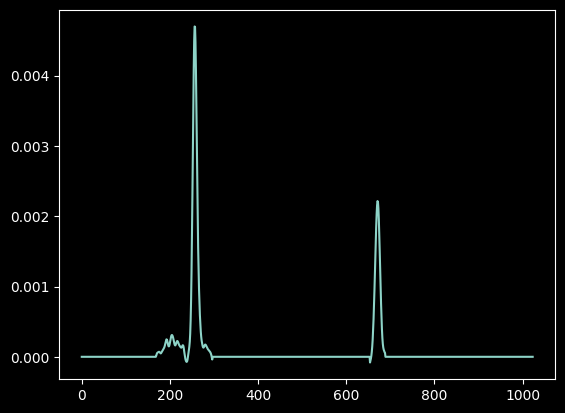

In [52]:
templatefilename=os.path.join("template.txt")# Enter the filename of your data here
template=np.loadtxt(templatefilename)
plt.plot(template)
plt.show()

In [51]:
##
#  This function will shift each row of a 2-d (3-d) array by the the number of columns specified in the "shifts" array.
#  data_in - the 2-d (3-d) array to work on
#  shifts - the shifts to apply
#  Returns: The shifted array
##
def shift_rows(data_in, shifts):
    shifted = np.zeros_like(data_in)
    if data_in.ndim == 3:
        for i in range(data_in.shape[0]):
            shifted[i] = shift_rows(data_in[i],shifts)
    else:
        for i in range(data_in.shape[0]):
            shifted[i] = np.roll(data_in[i],int(shifts[i]))
    return shifted


## Computing the time of arrivals
**Please don't worry too much about how this code works.** This is based on research software used for experiments ranging searching for planets around pulsars to measuring gravitational waves passing over the earth. It has been annotated with a few comments for the curious, but you can mostly just treat this as a black box you can use to get time of arrival measurements for your pulsar data.
If you are desparate to dig into the details, this code is based on the ToA estimation procedure described in Appendix A of Taylor et al. 1992. (https://www.jstor.org/stable/53915)

In [50]:

def get_toas(ddfreq_averaged,obsdata,plots=True):
    
    times=obsdata['times'] # The time of phase zero for each subint
    approx_period=obsdata['approx_period'] # The approximate period of the pulsar
    toas=[]
    toa_errs=[]
    tempo2_toas=[]

    # Equation A7 in Taylor 1992
    def get_dchi(tau,N,nbin):
        dphi = np.angle(xspec)[1:N]

        k=np.arange(1,N)

        dchi = np.sum(k*np.abs(f_prof[1:N])*np.abs(f_template[1:N]) * np.sin(dphi + 2*np.pi*k*tau/nbin))
        return dchi


    # Equation A9 in Taylor 1992
    def get_b(tau,N,nbin):
        dphi = np.angle(xspec)[1:N]
        k=np.arange(1,N)
        scale = np.sum(np.abs(f_prof[1:N])*np.abs(f_template[1:N]) * np.cos(dphi + 2*np.pi*k*tau/nbin))
        scale /= np.sum(np.abs(f_template[1:N])**2)
        return scale


    # Equation A10 in Taylor 1992
    def get_sigma_tau(tau,N,nbin,b):
        dphi = np.angle(xspec)[1:N]
        k=np.arange(1,N)
        chi2=np.sum(np.abs(f_prof[1:N])**2 + b**2*np.abs(f_template[1:N]) )-2*b*np.sum(np.abs(f_prof[1:N])*np.abs(f_template[1:N]) * np.cos(dphi + 2*np.pi*k*tau/nbin))
        sigma2 = chi2/(N-1)
        de = np.sum((k**2) * np.abs(f_prof[1:N])*np.abs(f_template[1:N]) * np.cos(dphi + 2*np.pi*k*tau/nbin))
        fac=nbin/(2*np.pi)
        return np.sqrt(sigma2/(2*b*de))*fac

    # Just for plotting, rotates an array by a fractional phase shift using Fourier transform
    def rotate_phs(ff,phase_shift):
        fr = ff*np.exp(-1.0j*2*np.pi*np.arange(len(ff))*phase_shift)
        return np.fft.irfft(fr)

    
    # Loop over every sub integration
    for ip in range(len(ddfreq_averaged)):
        try:
            prof=ddfreq_averaged[ip]
            nbin=len(prof)

            # We are going to do a cross correlation by means of the Fourier transform and the Wiener-Kinchin theorem
            f_template = np.fft.rfft(template)
            f_prof = np.fft.rfft(prof)

            # The cross correlation of a and b is the inverse transform of FT(a) times the conjugate of FT(b)
            xspec= f_template.conj() * f_prof # "cross spectrum"
            xcor = np.fft.irfft(xspec) # Cross correlation

            ishift = np.argmax(np.abs(xcor)) # estimate of the shift directly from the peak cross-correlation

            # We need to define some bounds to search. (Actually this might not be optimal)
            lo=ishift-1
            hi=ishift+1
            nh=len(xspec)
            # We minimise the chisquare parameter by findng the root of it's derivatiive following Taylor 1992 
            # This root_scalar method uses the 'Brent 1973' algorithm for root finding.
            ret = opt.root_scalar(get_dchi,bracket=(lo,hi),x0=ishift,args=(nh,nbin),method='brentq')

            # tau is the bin shift between data and template, which will become our ToA
            tau=ret.root
            # Again folow the math of Taylor 1992 to get the scale factor, which it calls 'b'
            scale=get_b(tau,nh,nbin)
            # And finally given the shift and scale we can find the uncertainty on the shift.
            sigma_tau=get_sigma_tau(tau,nh,nbin,scale)

            # Phase shift is bin shift divided by nbins
            phase_shift = tau/nbin

            # ToA is the phase shift converted to a time shift and added to the time of phase zero.
            toa = times[ip] + approx_period*tau/nbin/86400.0
            toa_err = approx_period*sigma_tau/nbin
            tempo2_toa=" test 611 {:.16f} {} jb42\n".format(toa,toa_err*1e6)

            toas.append(toa)
            toa_errs.append(toa_err)
            tempo2_toas.append(tempo2_toa)

            phase=np.linspace(0,1,nbin)

            rotate_and_scaled_template=scale*rotate_phs(f_template,phase_shift)
            diff=prof-rotate_and_scaled_template

            d= np.amax(prof)-np.amin(prof)
            if plots:
                # And do some plotting...
                plt.figure(figsize=(12,8))
                plt.xlabel("Pulse Phase")
                plt.ylabel("Flux Density (arbitrary)")

                plt.title(r"{} Profile {:d}:  $\delta t =$ {:.3f} $\pm$ {:.3f} ms".format(obsdata['source_name'],ip,1e3*approx_period*phase_shift,1e3*toa_err))
                plt.step(phase,prof,color='black',linewidth=1.0,label="Data")
                plt.plot(phase,rotate_and_scaled_template,color='red',label="Template")

                plt.step(phase,diff-d,color='green',linewidth=1.0,alpha=0.8,label=r"Data$-$template")
                plt.axhline(-d,ls=":",color='k')

                plt.xlim(0,1)
                plt.ylim(np.amin(prof)-1.2*d,np.amax(prof)+0.1*d)

                plt.legend(loc="lower left",ncol=3)

                plt.show()
                plt.close()
        except ValueError as e:
            print(e)
    return np.array(toas),np.array(toa_errs),tempo2_toas


# Your code - Dedisperse and make the ToAs
Here you can insert your dedispersion code from part 1, and then call the function to make toas

Data array shape: (3, 40, 1024)
Nsub = 3 Nchan = 40 Nphase= 1024


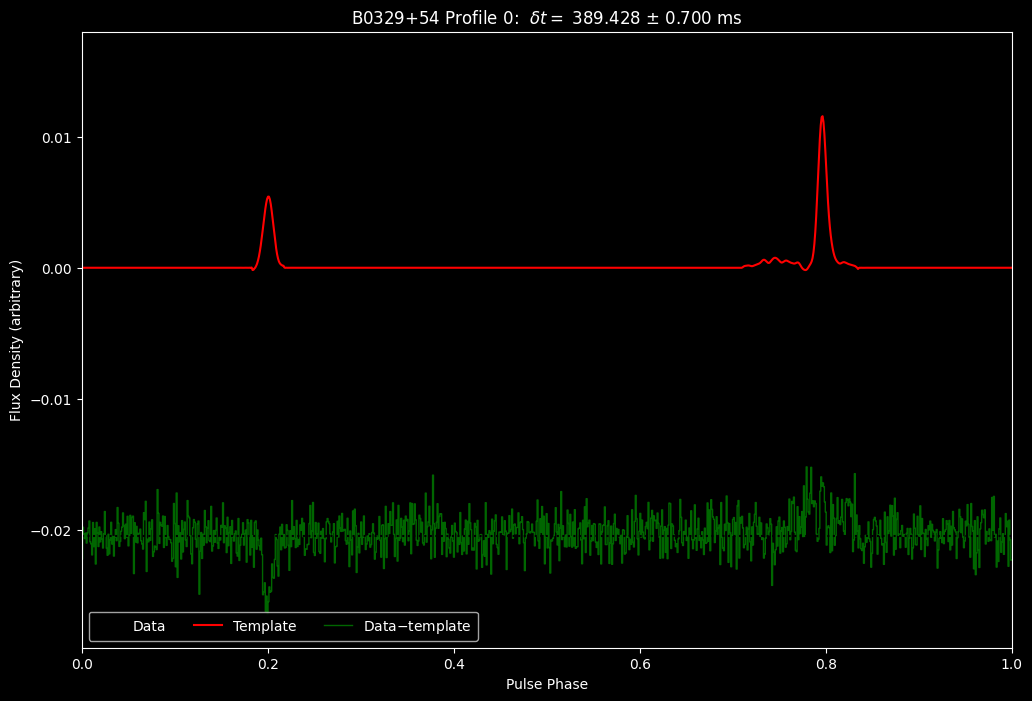

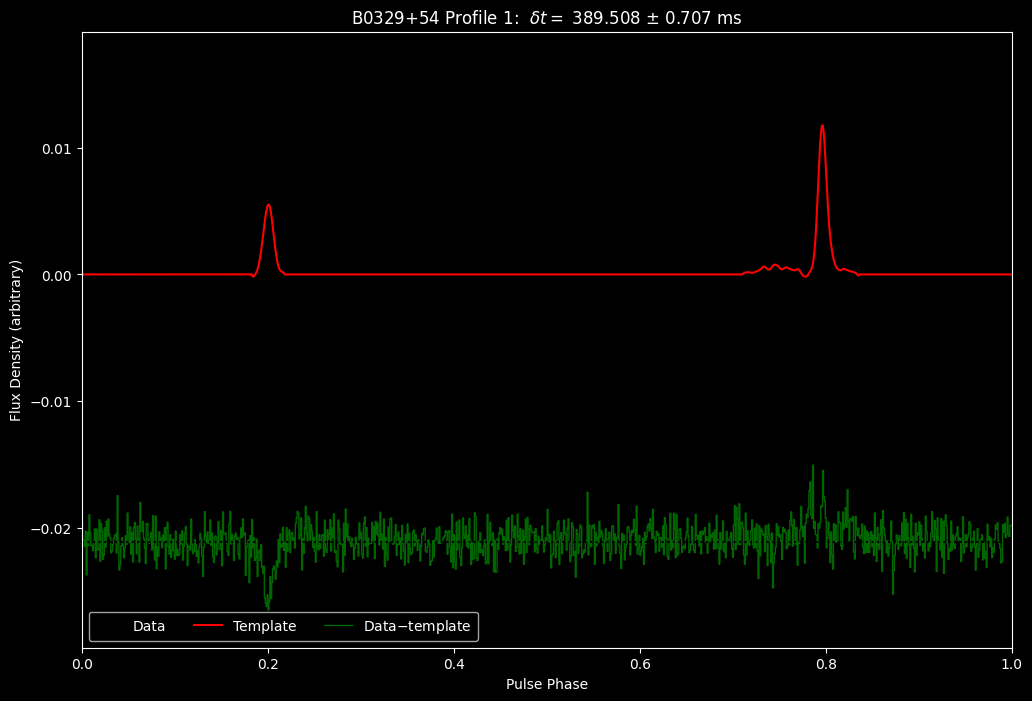

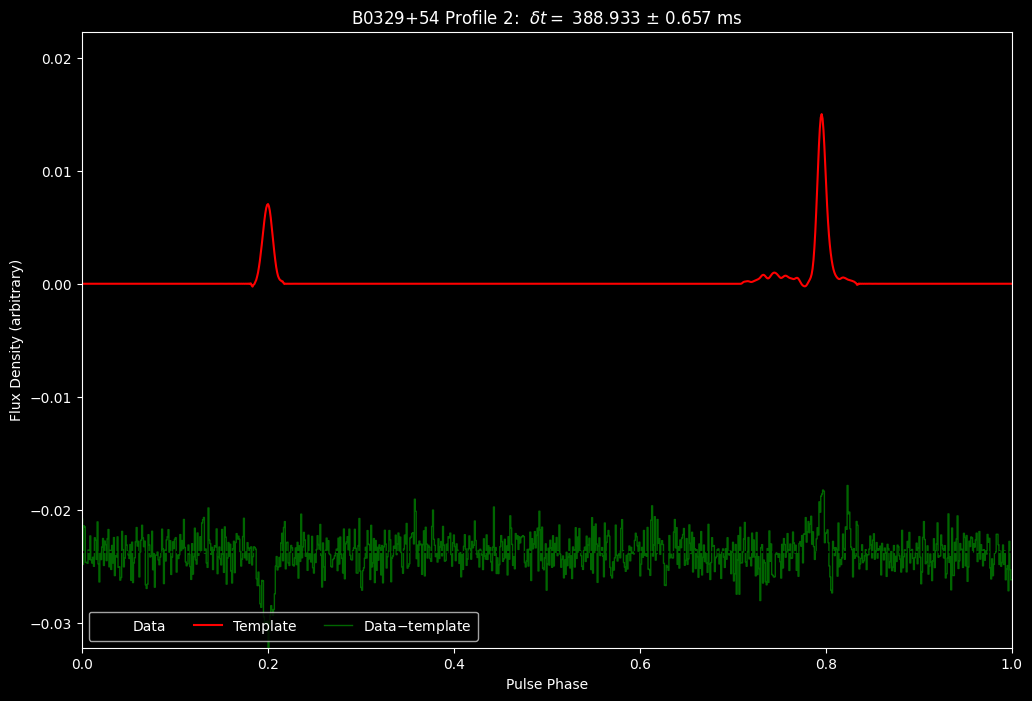

61074.702500896302808542 0.000651
61074.704791846110310871 0.000669
61074.706785047710582148 0.000621
[   1.            1.09990999    1.19981998 ...  999.80018002  999.90009001
 1000.        ]
Estimated DM = 25.678 pc cm^-3


In [72]:
#####################################################################


data = obsdata['data']
print("Data array shape:",data.shape)

# Here we infer the number of channels and numnber of phase bins based on the last entry in the file.
nsub, nchan,nphase = data.shape

# Print this out for verification
print("Nsub = {} Nchan = {} Nphase= {}".format(nsub, nchan,nphase))


# Here is where we reshape the 1-d array into a 2-d data structure
iphase=np.arange(nphase)
ichan=np.arange(nchan)
isub = np.arange(nsub)

# We can integrate over all frequency channels by using the `sum` routine from numpy...
fully_averaged=np.mean(data,axis=(0,1))
time_averaged = np.mean(data,axis=0)
freq_averaged = np.mean(data,axis=1)

##
#  This function will shift each row of a 2-d (3-d) array by the the number of columns specified in the "shifts" array.
#  data_in - the 2-d (3-d) array to work on
#  shifts - the shifts to apply
#  Returns: The shifted array
def shift_rows(data_in, shifts):
    shifted = np.zeros_like(data_in)
    if data_in.ndim == 3:
        for sub in range(nsub):
            shifted[sub] = shift_rows(data_in[sub],shifts)
    else:
        for chan in range(nchan):
            shifted[chan] = np.roll(data_in[chan],int(shifts[chan]))
    return shifted

# This example scaling is wrong - you need to determine the right values to scale!
#freq = 50 + ichan * 5
# right scaling
f_c = 611        # MHz (central frequency)
bw = 10          # MHz total bandwidth

P = 0.71442775        # seconds, pulsar period
DM = 50        # pc cm^-3, trial dispersion measure

nchan = time_averaged.shape[0]

freq = np.linspace(
    f_c - bw/2,
    f_c + bw/2,
    nchan
)

# Time resolution per phase bin
dt = P / nphase   # seconds per bin


###############################################################################
# Compute dispersion delay
###############################################################################
# Dispersion constant
K = 4.148808e3  # ms MHz^2 pc^-1 cm^3

# Reference frequency (highest frequency channel)
nu_ref = freq.max()

# Delay relative to reference frequency
delay_s = K * DM * (freq**-2 - nu_ref**-2)

# Convert delay to phase-bin shifts (negative = de-disperse)
bindelay = -np.round(delay_s / dt).astype(int)

dedispersed = shift_rows(time_averaged,bindelay)
# Again, sum along axis zero to integrate over frequency.
integrated=np.sum(dedispersed,axis=0)

#####################################################################
# Create a de-dispersed frequency-averaged data called ddfreq_averaged
ddfreq_averaged = np.mean(shift_rows(data, bindelay), axis=1)
nsub, nchan,nphase = data.shape
ichan=np.arange(nchan)

toas,*_ = get_toas(ddfreq_averaged, obsdata)

with open(filename+".toas.txt","w") as outf:
    for t,e in zip(toas,toa_errs):
        print("{:.18f} {:.3g}".format(t,e))
        outf.write("{:.18f} {:.3g}\n".format(t,e))


###############################################################################
# Estimate Dispersion Measure by maximizing S/N
###############################################################################

# Trial DM range (adjust as needed)
DM_trials = np.linspace(1, 1000, 10000)   # pc cm^-3
print(DM_trials)
snr_vals = []

for DM_try in DM_trials:
    # Dispersion delay (seconds)
    delay_s = K * DM_try * (freq**-2 - nu_ref**-2)

    # Convert to phase-bin shifts
    bindelay = -np.round(delay_s / dt).astype(int)

    # De-disperse
    dedisp = shift_rows(time_averaged, bindelay)

    # Integrate over frequency
    prof = np.sum(dedisp, axis=0)

    # Simple S/N estimate
    peak = np.max(prof)
    rms = np.std(prof)
    snr = peak / rms

    snr_vals.append(snr)

snr_vals = np.array(snr_vals)

# Best-fit DM
best_DM = DM_trials[np.argmax(snr_vals)]

print("Estimated DM = {:.3f} pc cm^-3".format(best_DM))
